In [180]:
import pickle
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [181]:
from keras.models import Model
from tensorflow.keras.models import load_model

#### 1. Load and visualise original ECG signals

In [182]:
import sys
sys.path.append('../') # Append the path to the root of the project to sys.path

In [183]:
from src.dataset import EcgSignalProcessor

In [184]:
with open('../data/processed/autoencoder_data.pkl', 'rb') as f:
    ecg_data = pickle.load(f)
test_user_ids = list(set(ecg_data['y_test']))
print(test_user_ids[42])

592


In [185]:
ecg_processor = EcgSignalProcessor(
    data_path='../data/raw/autonomic-aging-cardiovascular/1.0.0', 
    templates_to_extract=1000
)
X = ecg_processor.read_user_ecg_signals(test_user_ids[42])

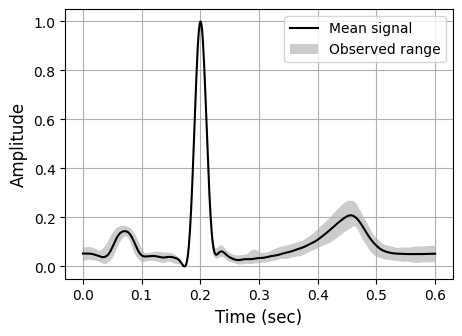

In [186]:
fig, ax = plt.subplots(figsize=(5, 3.5))
t_arr = np.linspace(0, len(X[0])/1000, len(X[0]))
ax.plot(t_arr, np.mean(X, axis=0), color='black', label='Mean signal')
ax.fill_between(
    t_arr,
    np.min(X, axis=0),
    np.max(X, axis=0),
    alpha=0.2,
    color='black',
    edgecolor=None,
    label='Observed range'
)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend()
ax.grid()
fig.savefig('../figures/inference/original_ecg.pdf', bbox_inches='tight')
plt.show()

#### 2. Load autoencoder model

In [187]:
model = load_model(f'../models/dense/LeakyReLU_BatchNorm_Latent32_512-256-128.keras')
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       479,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 600)            │       480,216 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,872,426 (10.96 MB)

 Trainable params: 956,280 (3.65 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 1,912,562 (7.30 MB)

In [188]:
encoder = model.get_layer('encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 512)            │       307,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,648 (1.83 MB)

 Trainable params: 477,856 (1.82 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [189]:
decoder = model.get_layer('decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 600)            │       307,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,216 (1.83 MB)

 Trainable params: 478,424 (1.83 MB)

 Non-trainable params: 1,792 (7.00 KB)

#### 3. Independent normal distributions

In [190]:
encoded_signals = encoder.predict(X)
n_features = encoded_signals.shape[1] # 32

mean_arr = []
std_arr = []

for i in range(n_features):
    latent_feature = encoded_signals[:, i]
    mu, std = norm.fit(latent_feature)
    mean_arr.append(mu)
    std_arr.append(std)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [191]:
latent_samples = []
for i in range(n_features):
    feature_samples = np.random.normal(mean_arr[i], std_arr[i], 10)
    latent_samples.append(feature_samples)
latent_samples = np.array(latent_samples).T
latent_samples.shape

(10, 32)

In [192]:
syntethic_signals_1d = decoder.predict(latent_samples)
syntethic_signals_1d.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


(10, 600)

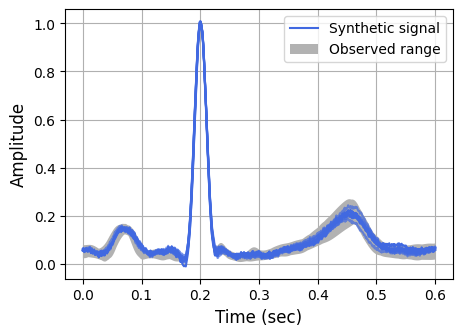

In [193]:
fig, ax = plt.subplots(figsize=(5, 3.5))
t_arr = np.linspace(0, len(X[0])/1000, len(X[0]))
ax.plot(t_arr, syntethic_signals_1d[0], color='royalblue', label='Synthetic signal')
ax.fill_between(
    t_arr,
    np.min(X, axis=0),
    np.max(X, axis=0),
    alpha=0.3,
    color='black',
    edgecolor=None,
    label='Observed range'
)
for i in range(1, 10):
    ax.plot(t_arr, syntethic_signals_1d[i], alpha=0.7, color='royalblue')
ax.set_xlabel('Time (sec)', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend()
ax.grid()
fig.savefig(f'../figures/inference/synthetic_ecg_independent.pdf', bbox_inches='tight')
plt.show()

#### 4. Mixture of independent normal distributions

In [194]:
from sklearn.mixture import GaussianMixture

encoded_signals = encoder.predict(X)
n_features = encoded_signals.shape[1]

gmm_models = []

for i in range(n_features):
    latent_feature = encoded_signals[:, i].reshape(-1, 1)  # Reshape for sklearn
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(latent_feature)
    gmm_models.append(gmm)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [195]:
latent_samples = []
for i in range(n_features):
    feature_samples = gmm_models[i].sample(10)[0]
    latent_samples.append(feature_samples)
latent_samples = np.concatenate(latent_samples, axis=1)
latent_samples.shape

(10, 32)

In [196]:
syntethic_signals_gmm = decoder.predict(latent_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


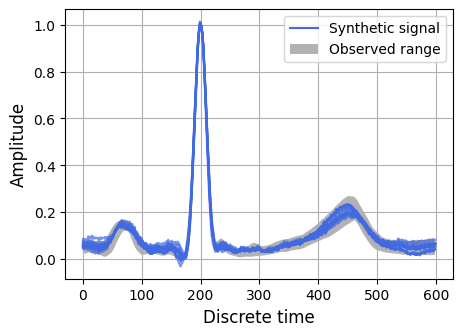

In [197]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(syntethic_signals_gmm[0], color='royalblue', label='Synthetic signal')
ax.fill_between(
    np.arange(0, len(X[0])),
    np.min(X, axis=0),
    np.max(X, axis=0),
    alpha=0.3,
    color='black',
    edgecolor=None,
    label='Observed range'
)
for i in range(1, 10):
    ax.plot(syntethic_signals_gmm[i], alpha=0.7, color='royalblue')
ax.set_xlabel('Discrete time', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend()
ax.grid()

fig.savefig(f'../figures/inference/synthetic_ecg_mixture.pdf', bbox_inches='tight')
plt.show()

#### 5. Multivariate distribution

In [198]:
mean_vector = np.mean(encoded_signals, axis=0)
cov_matrix = np.cov(encoded_signals, rowvar=False)

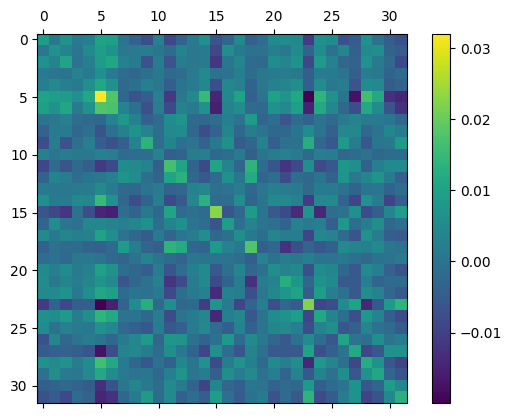

In [20]:
# Visualize the covariance matrix
fig, ax = plt.subplots()
cax = ax.matshow(cov_matrix, cmap='viridis')
fig.colorbar(cax)
plt.savefig(f'../figures/inference/covariance_matrix.pdf', bbox_inches='tight')
plt.show()

In [199]:
latent_samples = np.random.multivariate_normal(mean_vector, cov_matrix, 10)

In [200]:
syntethic_signals_md = decoder.predict(latent_samples)
syntethic_signals_md.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


(10, 600)

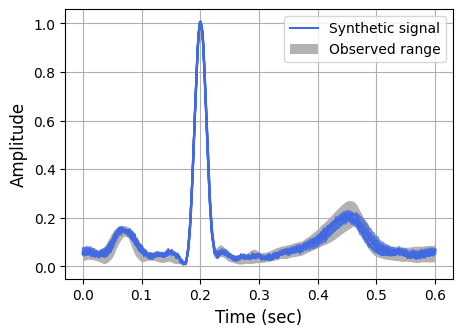

In [201]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(t_arr, syntethic_signals_md[0], color='royalblue', label='Synthetic signal')
t_arr = np.linspace(0, len(X[0])/1000, len(X[0]))
ax.fill_between(
    t_arr,
    np.min(X, axis=0),
    np.max(X, axis=0),
    alpha=0.3,
    color='black',
    edgecolor=None,
    label='Observed range'
)
for i in range(1, 10):
    ax.plot(t_arr, syntethic_signals_md[i], alpha=0.7, color='royalblue')
ax.set_xlabel('Time (sec)', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend()
ax.grid()

plt.savefig(f'../figures/inference/synthetic_ecg_multidimensional.pdf', bbox_inches='tight')
plt.show()

#### Visualise distributions

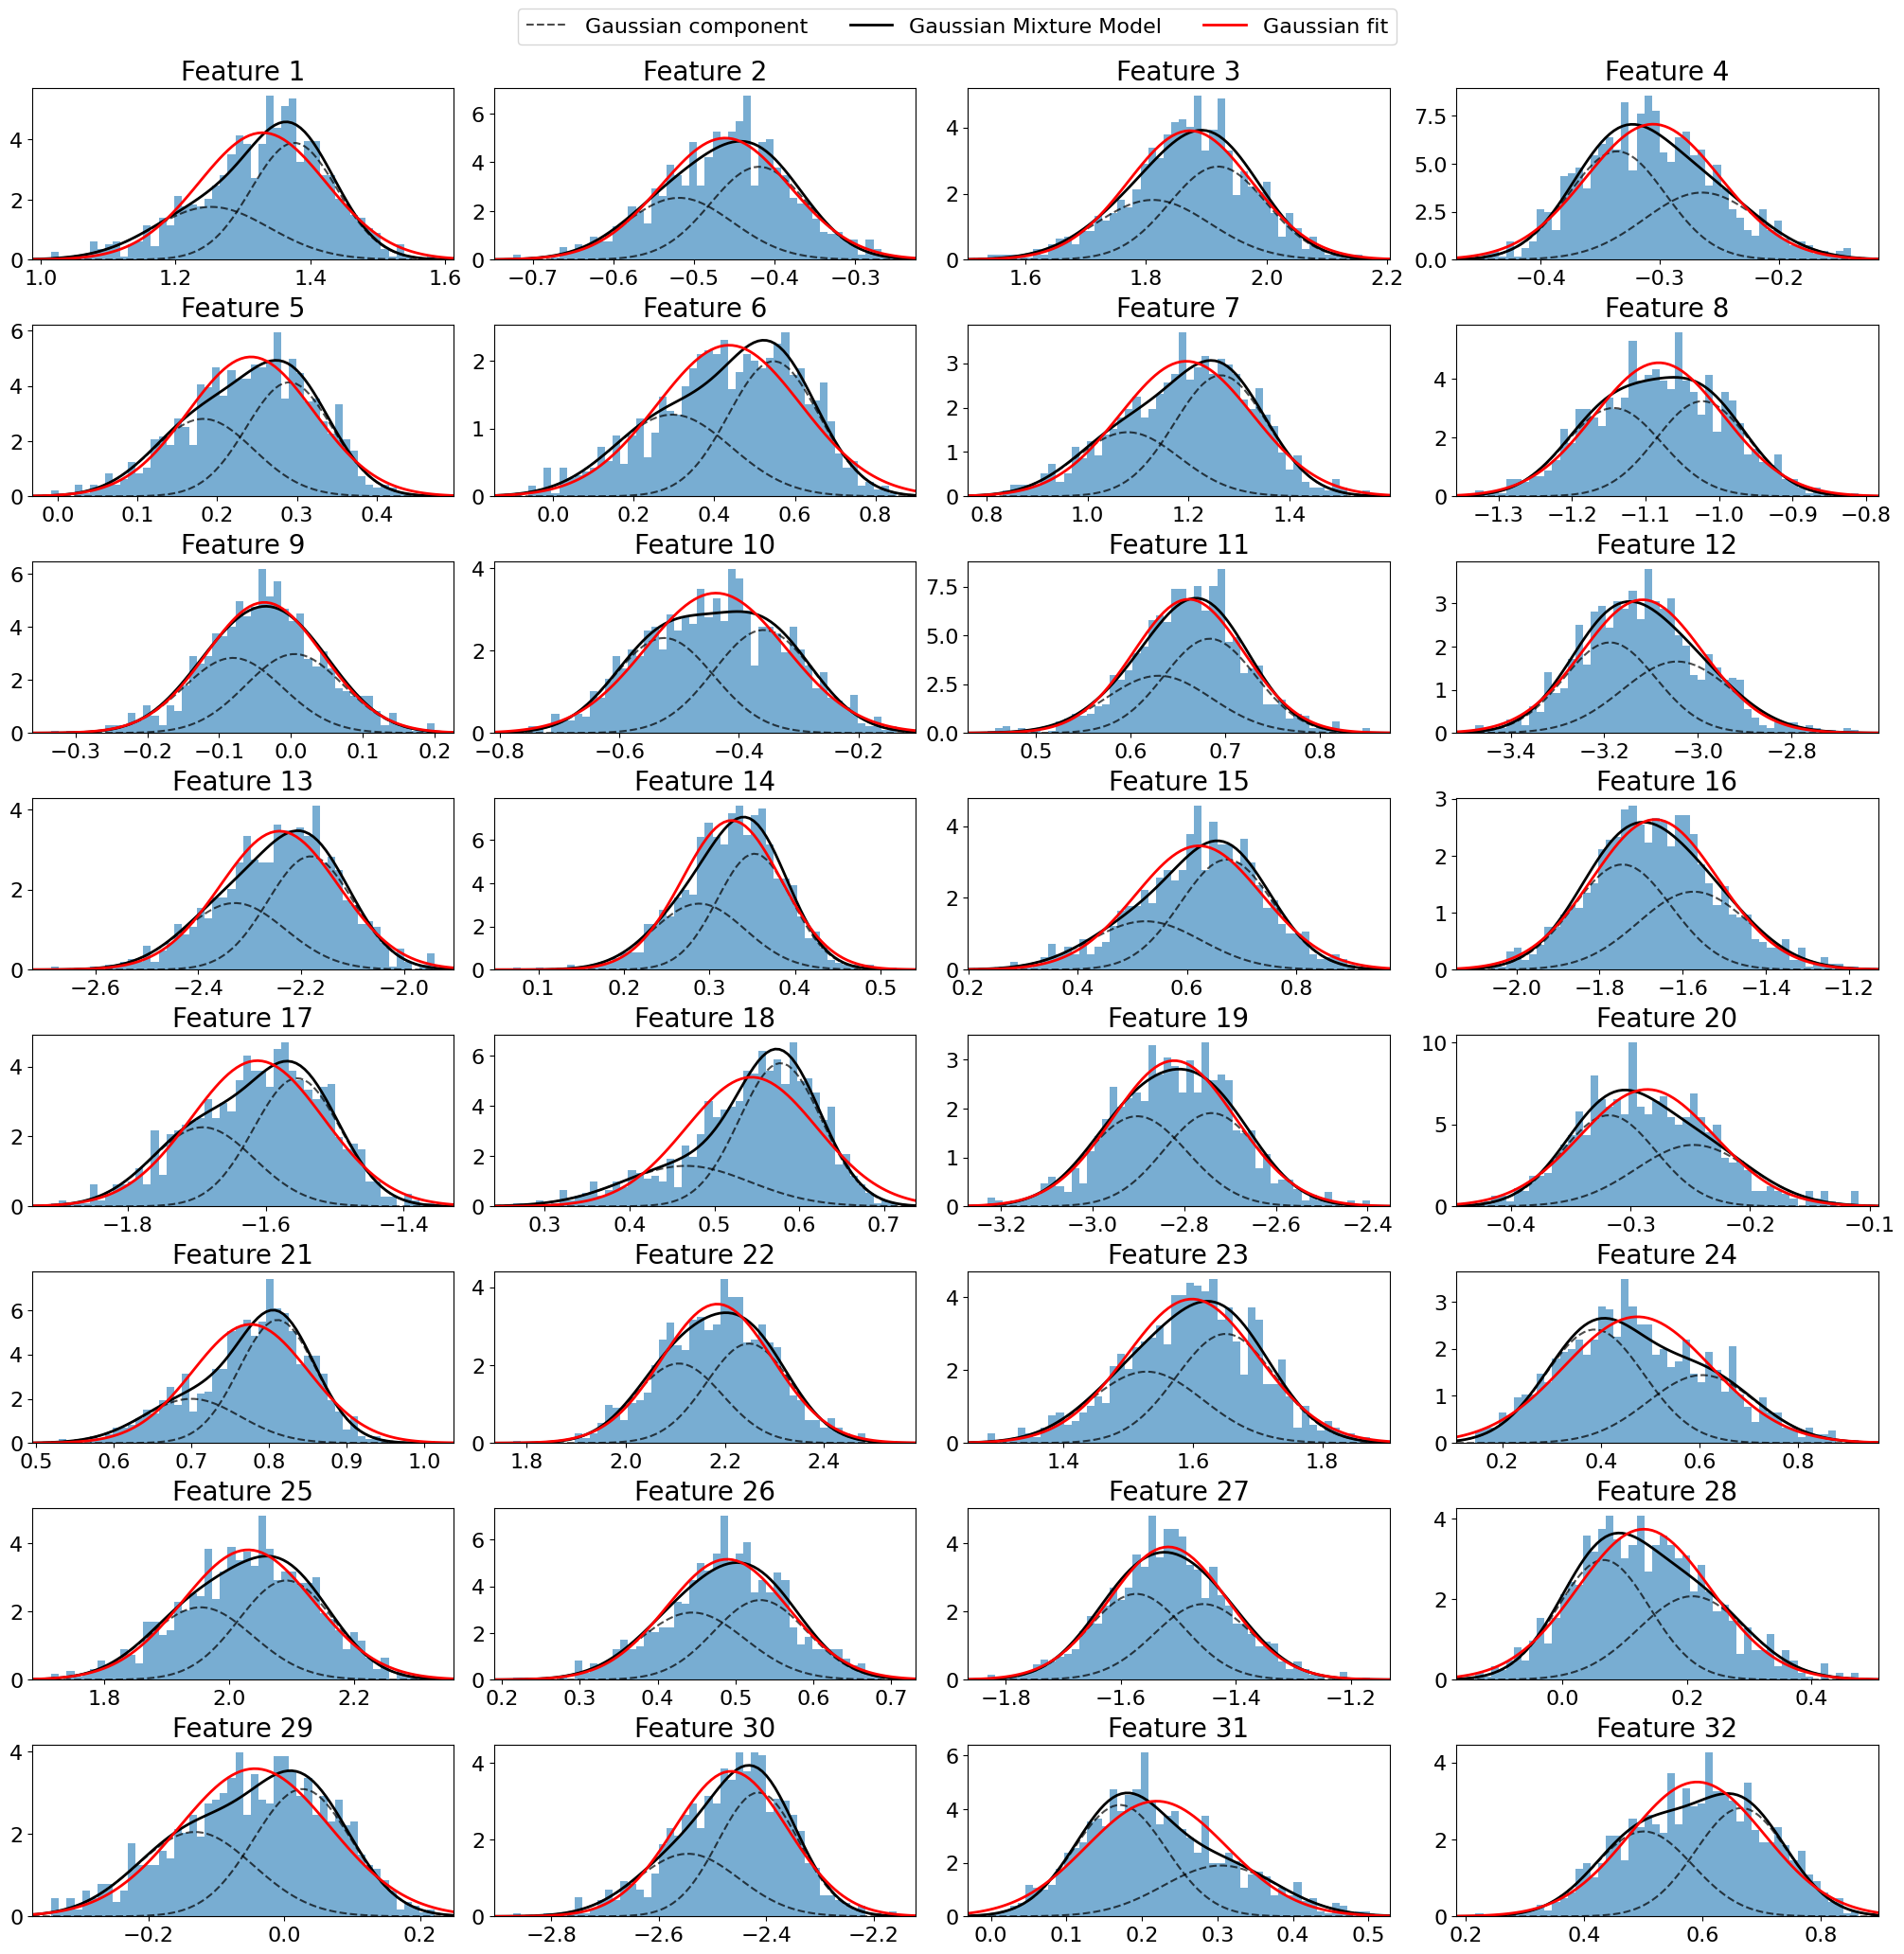

In [25]:
fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(20, 20), constrained_layout=True)
plt.rcParams.update({'font.size': 16})

for i in range(n_features):
    row = i // 4
    col = i % 4
    latent_feature = encoded_signals[:, i]
    ax[row, col].hist(latent_feature, bins=50, density=True, alpha=0.6, color='tab:blue')
    
    xmin, xmax = ax[row, col].set_xlim()
    x = np.linspace(xmin, xmax, 100)
    
    # For each component in the GMM, plot its Gaussian distribution
    distribution = np.zeros_like(x)
    legend_flag = False
    for mean, cov, weight in zip(gmm_models[i].means_.flatten(), gmm_models[i].covariances_.flatten(), gmm_models[i].weights_.flatten()):
        p = weight * norm.pdf(x, mean, np.sqrt(cov))
        distribution += p
        if not legend_flag:
            ax[row, col].plot(x, p, '--', color='black', alpha=0.7, label='Gaussian component')
            legend_flag = True
        else:
            ax[row, col].plot(x, p, '--', color='black', alpha=0.7)
    ax[row, col].plot(x, distribution, linewidth=2, color='black', label='Gaussian Mixture Model')

    p = norm.pdf(x, mean_arr[i], std_arr[i])
    ax[row, col].plot(x, p, 'red', linewidth=2, label='Gaussian fit')
    
    ax[row, col].set_title(f'Feature {i+1}', fontsize=20)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.74, 1.03), ncol=3)
# ax[0,0].legend(bbox_to_anchor=(3.6, 1.6), ncol=3)

# plt.tight_layout()
plt.savefig(f'../figures/inference/latent_features_distribution.pdf', bbox_inches='tight')
plt.show()

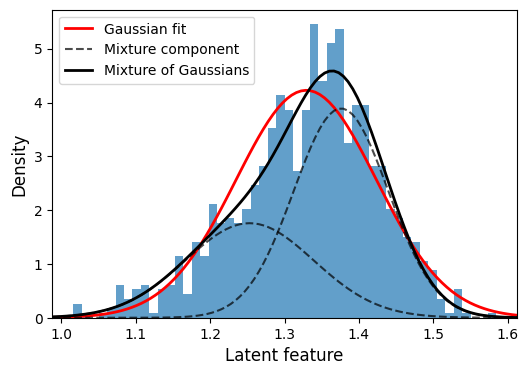

In [82]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams.update({'font.size': 10})

observations = encoded_signals[:, 0]
ax.hist(observations, bins=50, density=True, alpha=0.7, color='tab:blue')
    
xmin, xmax = ax.set_xlim()
x = np.linspace(xmin, xmax, 100)

p = norm.pdf(x, mean_arr[0], std_arr[0])
ax.plot(x, p, 'red', linewidth=2, label='Gaussian fit')

mean = gmm_models[0].means_.flatten()
cov = gmm_models[0].covariances_.flatten()
weight = gmm_models[0].weights_.flatten()
distribution = np.zeros_like(x)
legend_flag = False
for m, c, w in zip(mean, cov, weight):
    p = w * norm.pdf(x, m, np.sqrt(c))
    distribution += p
    if not legend_flag:
        ax.plot(x, p, '--', color='black', alpha=0.7, label='Mixture component')
        legend_flag = True
    else:
        ax.plot(x, p, '--', color='black', alpha=0.7)
ax.plot(x, distribution, linewidth=2, color='black', label='Mixture of Gaussians')

ax.set_xlabel('Latent feature', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend()

plt.savefig(f'../figures/distribution_example.pdf', bbox_inches='tight')
plt.show()